In [1]:
import sys
import os
import warnings
import logging
import numpy as np
import pandas as pd
import random as rn
import imblearn

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

import helper_functions.config as config
import helper_functions.data_functions as data_functions
import helper_functions.plotting_functions as plotting_functions

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating

def warn(*args, **kwargs):
    pass

tf.get_logger().setLevel(logging.ERROR)
warnings.warn = warn

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

os.environ['PYTHONHASHSEED']=str(42)

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print(f"Imbalanced-Learn {imblearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1
Imbalanced-Learn 0.7.0

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
def test_datasets(datasets, hyperparameters):
    history_list = []
    training_predictions_list = []
    training_true_fires_list = []
    testing_predictions_list = []
    testing_true_fires_list = []
    results_list = []
    
    metrics = hyperparameters['metrics']
    
    epochs = hyperparameters['epochs']
    future_target = hyperparameters['future_target']
    step = hyperparameters['step']
    learning_rate = hyperparameters['learning_rate']
    past_history = hyperparameters['past_history']
    batch_size = hyperparameters['batch_size']
    rnn_type = hyperparameters['rnn_type']
    statefullness = hyperparameters['statefullness']
    rnn_units = hyperparameters['rnn_units']
    rnn_dropout = hyperparameters['rnn_dropout']
    fc_unit_factor = hyperparameters['fc_unit_factor']
    fc_layers = hyperparameters['fc_layers']
    fc_l2_reg = hyperparameters['fc_l2_reg']

    # Load data
    for dataset in datasets.values():
        # read data
        raw_data = pd.read_parquet(dataset)

        # make sure data is sorted by date
        raw_data['date'] = pd.to_datetime(raw_data['date'])
        raw_data = raw_data.set_index('date')
        raw_data = raw_data.sort_index()
        raw_data.reset_index(inplace=True)
        
        barstow = raw_data[(raw_data['raw_lat'] == 35.232731) & (raw_data['raw_lon'] == -117.260803)]
        #lexington = raw_data[(raw_data['raw_lat'] == 37.182751) & (raw_data['raw_lon'] == -121.959801)]
        #cantua = raw_data[(raw_data['raw_lat'] == 36.557789) & (raw_data['raw_lon'] == -120.359802)]
        klamath = raw_data[(raw_data['raw_lat'] == 41.552299) & (raw_data['raw_lon'] == -123.944199)]
        
        data = pd.concat([barstow, klamath])
        
        class_0_weight = ()
        class_1_weight = ()
        bins = data.groupby(['raw_lat', 'raw_lon'])

        for name, spatial_bin in bins:
            fires = spatial_bin['ignition'].sum()

            if fires == 0:
                class_0_weight = class_0_weight + (1,)
                class_1_weight = class_1_weight + (1,)

            else:
                observations = len(spatial_bin)
                class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
                class_1_weight = class_1_weight + (((1 / fires)*(observations)/2.0),)
                
        num_fires = data['ignition'].sum()
        total_observations = len(data)
        raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
        output_bias = tf.keras.initializers.Constant(raw_output_bias)

        # make sure data is STILL sorted by date
        data['date'] = pd.to_datetime(data['date'])
        data = data.set_index('date')
        data = data.sort_index()
        data.reset_index(inplace=True)

        # Split data up into training, testing and validation sets
        testing_data = data.tail(int(len(data) * 0.2))
        leftover_data = data.head(int(len(data) * 0.8))
        validation_data = data.tail(int(len(leftover_data) * 0.5))
        training_data = data.head(int(len(leftover_data) * 0.5))

        # create data sets
        x_training, y_training, training_lats, training_lons, training_dates = data_functions.format_features_labels_for_LSTM(
            training_data,        # incomming_data
            past_history,         # size of past history time chunk
            future_target,        # number of future timepoints to predict from each history time chunk
            step,                 # number of timepoints to move the history time chunk as we slide over the data
        )

        x_validation, y_validation, validation_lats, validation_lons, validation_dates = data_functions.format_features_labels_for_LSTM(
            validation_data,      # incomming_data
            past_history,         # size of past history time chunk
            future_target,        # number of future timepoints to predict from each history time chunk
            step,                 # number of timepoints to move the history time chunk as we slide over the data
        )
        
        x_testing, y_testing, testing_lats, testing_lons, testing_dates = data_functions.format_features_labels_for_LSTM(
            testing_data,         # incomming_data
            past_history,         # size of past history time chunk
            future_target,        # number of future timepoints to predict from each history time chunk
            step,                 # number of timepoints to move the history time chunk as we slide over the data
        )

        x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
        x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
        x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

        # trim datasets so they are a whole number factor of the batch size
        for i in range(len(x_training)):
            start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % batch_size))
            end_index = x_training[i].shape[0]

            x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

        y_training = np.delete(y_training, range(start_index, end_index), axis=0)

        for i in range(len(x_validation)):
            start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % batch_size))
            end_index = x_validation[i].shape[0]

            x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

        y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
        
        for i in range(len(x_testing)):
            start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % batch_size))
            end_index = x_testing[i].shape[0]

            x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

        y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)
        
        input_dim = x_training[0].shape[-2:]
        input_shape = (batch_size, input_dim[0], input_dim[1])
        num_bins = len(x_training)
    #     print(f'Input shape: {input_shape}')
    #     print(f'Num bins: {num_bins}')
    #     print()

        # steps from batch size
        steps_per_epoch = int(len(x_training[0]) // batch_size)
        validation_steps = int(len(x_validation[0]) // batch_size)
        
        if hyperparameters['verbose'] != 0:
            print()
            print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
            print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
            print()
            print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
            print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
            print()
            print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
            print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))
            print()

        if statefullness == 0:
            statefullness = False

        elif statefullness == 1:
            statefullness = True

        inputs = []
        RNNs = []

        # make list of inputs, one for each geospatial bin
        for i in range(num_bins):
            inputs.append(
                keras.Input(
                    batch_shape=input_shape
                )
            )

        if rnn_type == 0:
            # make list of LSTM layers, one for each geospatial bin
            for i in range(num_bins):
                RNNs.append(keras.layers.LSTM(
                    rnn_units,
                    dropout=rnn_dropout,
                    stateful=statefullness
                )(inputs[i]))

        elif rnn_type == 1:
            # make list of GRU layers, one for each geospatial bin
            for i in range(num_bins):
                RNNs.append(keras.layers.GRU(
                    rnn_units,
                    dropout=rnn_dropout,
                    stateful=statefullness
                )(inputs[i]))

        # merge LSTM layers with concat layer
        merged = keras.layers.concatenate(RNNs)

        if fc_layers == 0:
            # output layer
            output = keras.layers.Dense(
                num_bins,
                activation='sigmoid',
                bias_initializer=output_bias
            )(merged) 


        elif fc_layers > 0:
            i = 0
            io_layers = []
            io_layers.append(merged)

            while i <= fc_layers:
                # add fully connected layer
                io_layers.append(keras.layers.Dense(
                    (num_bins * fc_unit_factor),
                    kernel_regularizer=regularizers.l2(fc_l2_reg),
                    bias_initializer=keras.initializers.VarianceScaling(
                        scale=1.0,
                        mode='fan_in', 
                        distribution='normal', 
                        seed=42
                    ),
                    activation = 'relu'
                )(io_layers[i]))

                i += 1

            # output layer
            output = keras.layers.Dense(
                num_bins,
                activation='sigmoid',
                bias_initializer=output_bias
            )(io_layers[-1])        

        # compile model
        model = keras.Model(inputs=inputs, outputs=output)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
            loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
            metrics = metrics
        )

        # Train model
        history = model.fit(
            x_training,
            y_training,
            epochs=epochs,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            callbacks=[early_stopping_callback],
            validation_data=(x_validation, y_validation),
            validation_steps=validation_steps,
            verbose=0
        )
        
        training_predictions = model.predict(x_training, batch_size=batch_size)
        training_ignition_risk_predictions = training_predictions.flatten()
        training_true_fires = y_training.flatten()

        testing_predictions = model.predict(x_testing, batch_size=batch_size)
        testing_ignition_risk_predictions = testing_predictions.flatten()
        testing_true_fires = y_testing.flatten()

        results = model.evaluate(
            x_testing,
            y_testing,
            batch_size=batch_size,
            verbose=hyperparameters['verbose']
        )

        history_list.append(history)
        training_predictions_list.append(training_ignition_risk_predictions)
        training_true_fires_list.append(training_true_fires)
        
        testing_predictions_list.append(testing_ignition_risk_predictions)
        testing_true_fires_list.append(testing_true_fires)
        results_list.append(results)
        
        K.clear_session()
        
    results = {'history_list': history_list,
            'training_predictions_list': training_predictions_list,
            'training_true_fires_list': training_true_fires_list,
            'testing_predictions_list': testing_predictions_list,
            'testing_true_fires_list': testing_true_fires_list,               
            'results_list': results_list,
            'y_training': y_training,
            'y_testing': y_testing
    }
    
    return results

In [3]:
# model hyperparameters
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    mode = 'min',
    restore_best_weights = True
)

hyperparameters = {
    'epochs': 25,
    'future_target': 1,
    'step': 1,
    'early_stopping_callback': early_stopping_callback,

    'learning_rate': 0.024848325851165635,
    'past_history': 7,
    'batch_size': 97,
    'rnn_type': 0,
    'statefullness': 1,
    'rnn_units': 1,
    'rnn_dropout': 0.02036440115948507,
    'fc_unit_factor': 3,
    'fc_layers': 2,
    'fc_l2_reg': 0.047469965525823804,

    'metrics': [
        keras.metrics.TruePositives(name='true_positives'),
        keras.metrics.FalsePositives(name='false_positives'),
        keras.metrics.TrueNegatives(name='true_negatives'),
        keras.metrics.FalseNegatives(name='false_negatives'), 
        keras.metrics.AUC(name='auc'),
        data_functions.matthews_correlation,
        data_functions.f1
    ],
    
    'verbose': 0
}

## Test 1: Scaling

In [4]:
# datasets for testing

datasets = {
    'Mean only: raw': '/mnt/SSD/data/training_data/1992-2015_california_raw_mean.parquet',
    'Mean only: (0, 1) scaled': '/mnt/SSD/data/training_data/1992-2015_california_min0_max1_scaled_mean.parquet',
    'Mean only: (-1, 1) scaled': '/mnt/SSD/data/training_data/1992-2015_california_min-1_max1_scaled_mean.parquet',
    'Mean only: z-score scaled': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet'
}

scaling_results = test_datasets(datasets, hyperparameters)

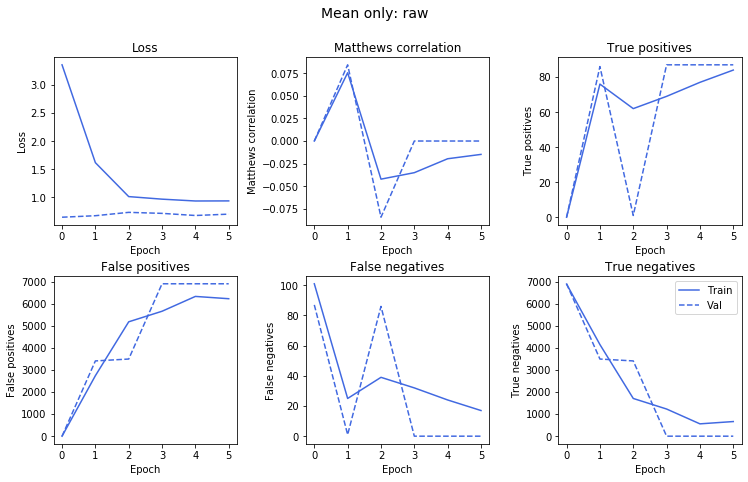

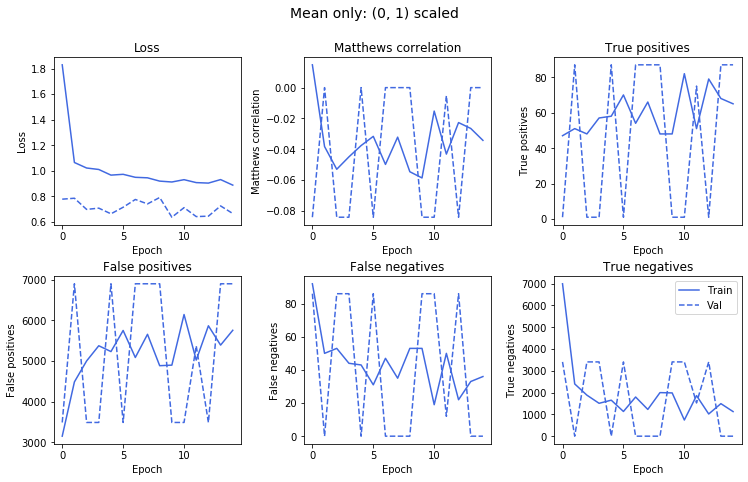

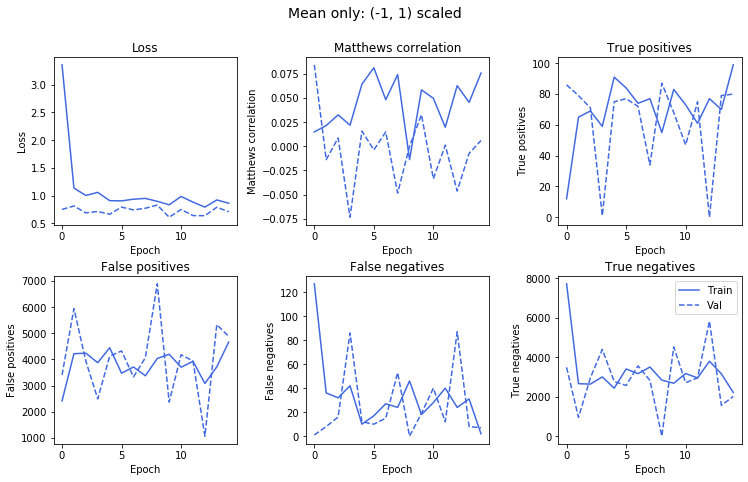

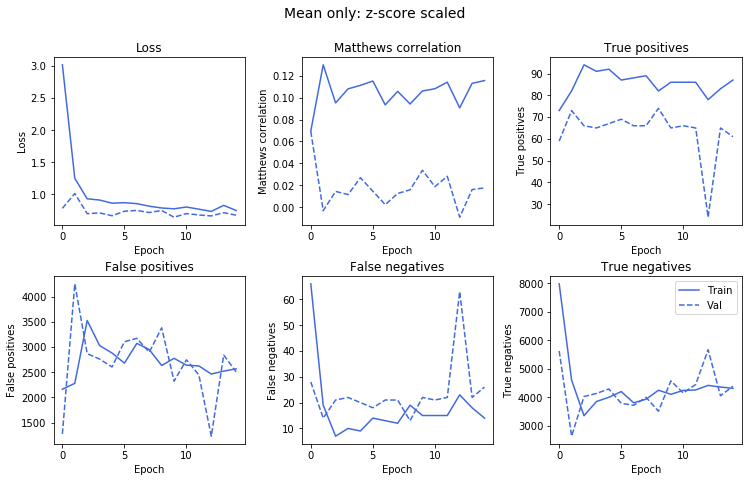

In [5]:
metric_names =  [
    'loss', 
    'matthews_correlation', 
    'true_positives', 
    'false_positives', 
    'false_negatives', 
    'true_negatives'
]

filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = scaling_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

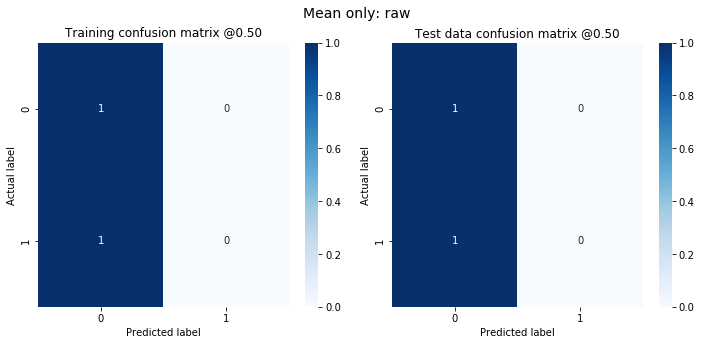

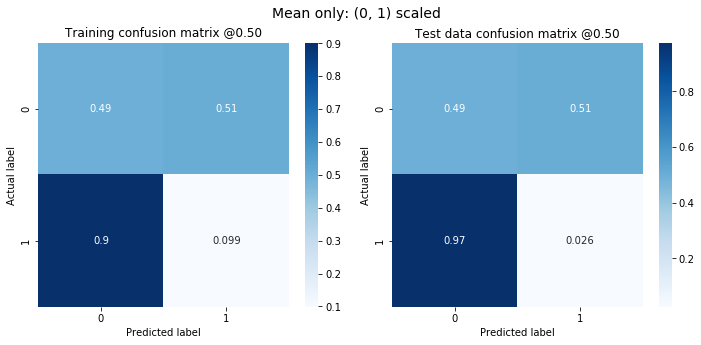

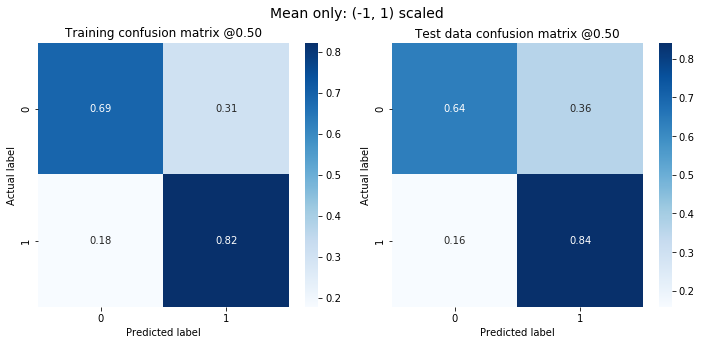

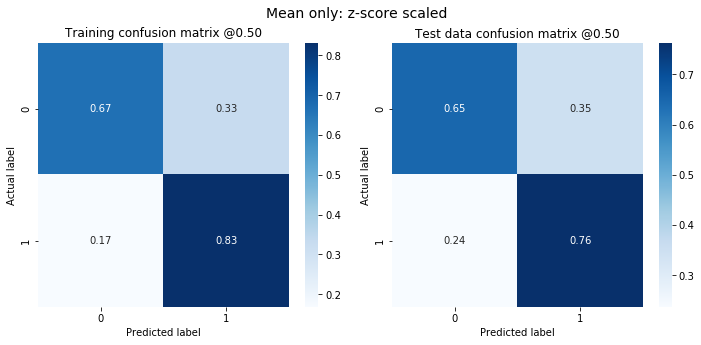

In [11]:
filename = '../project_info/figures/feature_engineering_test_confusion_matrices.png'

training_predictions_list = scaling_results['training_predictions_list']
training_true_fires_list = scaling_results['training_true_fires_list']
testing_predictions_list = scaling_results['testing_predictions_list']
testing_true_fires_list = scaling_results['testing_true_fires_list']

y_training = scaling_results['y_training']
y_testing = scaling_results['y_testing']

for train_predictions, y_train, test_predictions, y_test, title in zip(training_predictions_list, training_true_fires_list, testing_predictions_list, testing_true_fires_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 2: Box-Cox quantile transformation

In [ ]:
# datasets for testing

datasets = {
    'Mean only: z-score scaled': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean.parquet',
    'Mean only: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet',
    'Mean only: z-score scaled, full Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_full_box_cox.parquet'
}

boxcox_results = test_datasets(datasets, hyperparameters)

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = boxcox_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = boxcox_results['train_predictions_list']
test_predictions_list = boxcox_results['test_predictions_list']

y_train = boxcox_results['y_train']
y_test = boxcox_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 3: Min, max, range feature addition

In [ ]:
# datasets for testing

datasets = {
    'Mean only: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_selective_box_cox.parquet',
    'Mean, absolute min, max: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_abs_min_max_selective_box_cox.parquet',
    'Mean, plus-minus min, max: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_plus-minus_min_max_selective_box_cox.parquet',
    'Mean, range: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet'
}

min_max_results = test_datasets(datasets, hyperparameters)

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = min_max_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = min_max_results['train_predictions_list']
test_predictions_list = min_max_results['test_predictions_list']

y_train = min_max_results['y_train']
y_test = min_max_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 4: Month encoding

In [ ]:
# datasets for testing

datasets = {
    'Mean, range: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_selective_box_cox.parquet',
    'Mean, range, onehot month: z-score scaled, selective Box-Cox': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'
}

onehot_month_results = test_datasets(datasets, hyperparameters)

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = onehot_month_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = onehot_month_results['train_predictions_list']
test_predictions_list = onehot_month_results['test_predictions_list']

y_train = onehot_month_results['y_train']
y_test = onehot_month_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

## Test 5: Dimensionality reduction

In [ ]:
# datasets for testing

datasets = {
    'PCA: 5 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca5.parquet',
    'PCA: 10 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca10.parquet',
    'PCA: 15 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca15.parquet',
    'PCA: 20 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca20.parquet',
    'PCA: 25 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca25.parquet',
    'PCA: 30 components': '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox_pca30.parquet'
}

pca_results = test_datasets(datasets, hyperparameters)

In [ ]:
metric_names =  ['loss', 'f1', 'matthews_correlation', 'tp', 'fp', 'fn']
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

history_list = pca_results['history_list']

for history, dataset in zip(history_list, datasets.keys()):
    plotting_functions.plot_metrics(dataset, history, metric_names, filename)

In [ ]:
filename = '../project_info/figures/feature_engineering_test_learning_curves.png'

train_predictions_list = pca_results['train_predictions_list']
test_predictions_list = pca_results['test_predictions_list']

y_train = pca_results['y_train']
y_test = pca_results['y_test']

for train_predictions, test_predictions, title in zip(train_predictions_list, test_predictions_list, datasets.keys()):
    plotting_functions.plot_multiple_CMs(y_train, train_predictions, y_test, test_predictions, title, filename)

OK, conclusion time. Working in reverse:
    
1. PCA does not seem to offer any significant advantages for this dataset. It does reduce the size somewhat, but the in memory size of the data is not unmanageable to begin with. Let's keep this in mind for the future when and if we try to scale up to a larger geographic area.
2. Using a scalar vs one hot encoding for the month does not seem to make a significant difference in performance. For the sake of simplicity let's stick with the scalar month encoding.
3. Using a plus/minus mean value to encode variability seems like a bad idea. Using and absolute min and max variable seems similar to a single range variable. Since the separate absolute min, max values appear to work slightly better we will stick with that approach.
4. Using quantile transformation to enforce normal distributions on the data seems to help. Transforming all variables vs transforming only those with noticeably non-normal distributions gives similar results with the selective approach performing just slightly better in some trials.
5. Scaling improves performance significantly - all three scaling method tested give similar results with the standard scalar (z-score) winning by a few percentage points.

**Conclusion**

Best data set: z-score normalized, selectively Box-Cox quantile transformed, includes 'absolute' min and max for continuous weather variables and uses a scalar (also z-score normalized) to encode month. PCA can be used to reduce the size of the dataset but is not needed.